In [1]:
require(data.table)

Loading required package: data.table


In [2]:
featFull <- fread("../data/synapsinR_7thA.tif.Pivots.txt.2011Features.txt",
                  showProgress=FALSE)
locFull <- fread("../data/synapsinR_7thA.tif.Pivots.txt",showProgress=FALSE)

### Setting a seed and creating an index vector
### to select half of the data
set.seed(2^10)
half1 <- sample(dim(featFull)[1],dim(featFull)[1]/2)
half2 <- setdiff(1:dim(featFull)[1],half1)

feat <- featFull[half1,]
feat2 <- featFull[half2,]
loc <- locFull[half1,]

## Setting the channel names
channel <- c('Synap_1','Synap_2','VGlut1_t1','VGlut1_t2','VGlut2','Vglut3',
              'psd','glur2','nmdar1','nr2b','gad','VGAT',
              'PV','Gephyr','GABAR1','GABABR','CR1','5HT1A',
              'NOS','TH','VACht','Synapo','tubuli','DAPI')

## Setting the channel types
channel.type <- c('ex.pre','ex.pre','ex.pre','ex.pre','ex.pre','in.pre.small',
                  'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre',
                  'in.pre','in.post','in.post','in.post','in.pre.small','other',
                  'ex.post','other','other','ex.post','none','none')

nchannel <- length(channel)
nfeat <- ncol(feat) / nchannel

## Createing factor variables for channel and channel type sorted properly
ffchannel <- (factor(channel.type,
    levels= c("ex.pre","ex.post","in.pre","in.post","in.pre.small","other","none")
    ))
fchannel <- as.numeric(factor(channel.type,
    levels= c("ex.pre","ex.post","in.pre","in.post","in.pre.small","other","none")
    ))
ford <- order(fchannel)


## Setting up colors for channel types
Syncol <-  c("#197300","#5ed155","#660000","#cc0000","#ff9933","#0000cd","#ffd700")
Syncol3 <- c("#197300","#197300","#cc0000","#cc0000","#0000cd","#0000cd","#0000cd")
ccol <- Syncol[fchannel]
ccol3 <- Syncol3[fchannel]

exType <- factor(c(rep("ex",11),rep("in",6),rep("other",7)),ordered=TRUE)
exCol<-exType;levels(exCol) <- c("#197300","#990000","mediumblue");
exCol <- as.character(exCol)

fname <- as.vector(sapply(channel,function(x) paste0(x,paste0("F",0:5))))
names(feat) <- names(feat2) <- fname
fcol <- rep(ccol, each=6)
#mycol <- colorpanel(100, "purple", "black", "green")
mycol <- colorpanel(100, "black", "pink")
mycol2 <- matlab.like(nchannel)


ERROR: Error in eval(expr, envir, enclos): could not find function "colorpanel"


In [3]:
f <- lapply(1:6,function(x){seq(x,ncol(feat),by=nfeat)})
f2 <- lapply(1:6,function(x){seq(x,ncol(feat2),by=nfeat)})
featF <- lapply(f,function(x){subset(feat,select=x)})
featF2 <- lapply(f2,function(x){subset(feat2,select=x)})

featF0 <- featF[[1]]
featF02 <- featF2[[1]]
f01e3 <- 1e3*data.table(apply(X=featF0, 2, function(x){((x-min(x))/(max(x)-min(x)))}))
f01e32 <- 1e3*data.table(apply(X=featF02, 2, function(x){((x-min(x))/(max(x)-min(x)))}))

fs <- f01e3
fs2 <- f01e32

In [5]:
require(doMC)
registerDoMC(4)

Loading required package: doMC
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [9]:
dat <- fs
dat2 <- fs2
set.seed(1234)
smallDat <- dat[sample(dim(dat)[1], 500), ]

require(cstab)
require(flexclust)
require(fastcluster)
cst <- foreach(i = 1:8) %dopar% {
  cStability(smallDat, kseq = c(2:12))
}

Ins <- Reduce('cbind', lapply(cst, function(x) { return(x$Instab_path) }))
colnames(Ins) <- paste0("V", 1:8)

#plot(c(NA, Ins[[1]]), type = 'b', col = 'darkblue')
#for(i in 1:8){
#  lines(c(NA, Ins[[i]]), col = i, type = 'b')
#}




Loading required package: flexclust
Loading required package: grid
Loading required package: lattice
Loading required package: modeltools
Loading required package: stats4
Loading required package: fastcluster

Attaching package: ‘fastcluster’

The following object is masked from ‘package:stats’:

    hclust



In [26]:
mis <- melt(Ins)
head(mis)

Var1,Var2,value
1,V1,0.2082124
2,V1,0.2048625
3,V1,0.2562028
4,V1,0.2169964
5,V1,0.1696353
6,V1,0.1793507


In [41]:
lms <- c()
for(v in unique(mis$Var2)){
    lms <- c(lms, min(mis[mis$Var2 == v, "value"]))
}
lms <- data.frame(Var2 = unique(mis$Var2), lms)
lms

Var2,lms
V1,0.12590140
V2,0.11803768
V3,0.13503727
V4,0.12189419
V5,0.04322164
V6,0.04934028
V7,0.12588537
V8,0.12181884


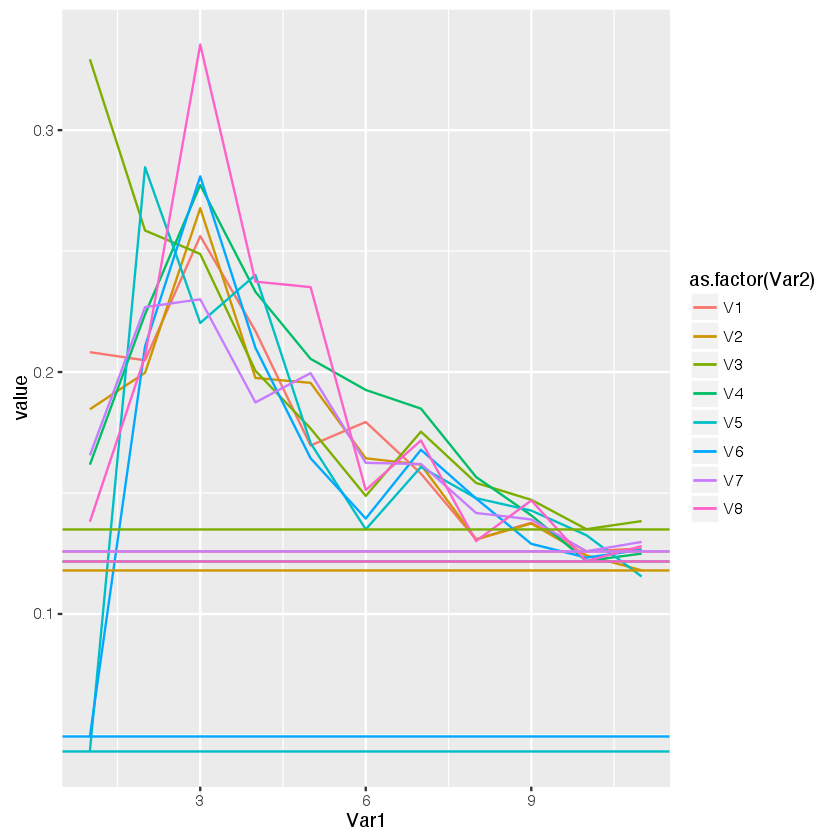

In [42]:
ggplot(mis, aes(x = Var1, y = value, group = Var2, color = as.factor(Var2))) + 
    geom_line() + 
    geom_hline(aes(yintercept = lms, color = as.factor(Var2)), lms)